In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random

import pandas as pd
import numpy as np
from linearmodels.panel import PanelOLS
import matplotlib.pyplot as plt
import random
from contextualized.easy import ContextualizedRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set all random seeds
seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Hyperparameters
num_stocks = 100
num_industries = 10
embedding_dim = 4
epochs = 500
lr = 0.01
reg_strength = 0.2  # weight for clustering loss

# Dummy stock-to-industry mapping (e.g. stocks 0–9 → industry 0, etc.)
stock_to_industry = torch.tensor([i // 10 for i in range(num_stocks)])

# Dummy prediction targets (e.g. simulate returns or labels)
# Just for training purposes — replace with real data
true_targets = torch.randn(num_stocks, 1)  # regression target per stock

# Dataset (each sample is one stock)
stock_ids = torch.arange(num_stocks)
industry_ids = stock_to_industry

# Model
class StockEmbedder(nn.Module):
    def __init__(self, num_stocks, num_industries, embedding_dim):
        super().__init__()
        self.stock_embedding = nn.Embedding(num_stocks, embedding_dim)
        self.industry_embedding = nn.Embedding(num_industries, embedding_dim)
        self.predictor = nn.Linear(embedding_dim, 1)  # Dummy prediction head
    
    def forward(self, stock_ids, industry_ids):
        stock_vecs = self.stock_embedding(stock_ids)         # [N, 4]
        industry_vecs = self.industry_embedding(industry_ids)  # [N, 4]
        preds = self.predictor(stock_vecs)  # dummy prediction task
        return stock_vecs, industry_vecs, preds

# Instantiate
embedder = StockEmbedder(num_stocks, num_industries, embedding_dim)
optimizer = optim.Adam(embedder.parameters(), lr=lr)
mse = nn.MSELoss()

# Training loop
for epoch in range(epochs):
    embedder.train()
    optimizer.zero_grad()

    stock_vecs, industry_vecs, preds = embedder(stock_ids, industry_ids)
    
    # Dummy regression loss
    prediction_loss = mse(preds, true_targets)

    # Clustering loss: encourage each stock embedding to stay close to its industry
    clustering_loss = mse(stock_vecs, industry_vecs)

    # Total loss
    loss = prediction_loss + reg_strength * clustering_loss
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Total Loss: {loss.item():.4f}")


Epoch 50/500, Total Loss: 0.7406
Epoch 100/500, Total Loss: 0.2244
Epoch 150/500, Total Loss: 0.1015
Epoch 200/500, Total Loss: 0.0659
Epoch 250/500, Total Loss: 0.0461
Epoch 300/500, Total Loss: 0.0338
Epoch 350/500, Total Loss: 0.0259
Epoch 400/500, Total Loss: 0.0207
Epoch 450/500, Total Loss: 0.0171
Epoch 500/500, Total Loss: 0.0146


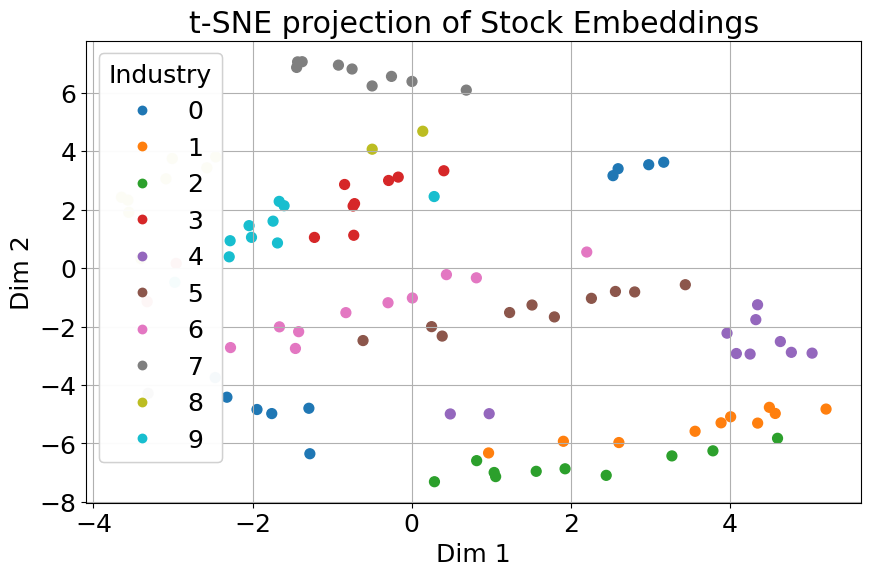

In [88]:
# ---- Visualize embeddings using t-SNE ----
embedder.eval()
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # [100, 4]
    industry_colors = stock_to_industry.numpy()

    # Reduce to 2D using t-SNE for visualization
    tsne = TSNE(n_components=2, random_state=42)
    stock_2d = tsne.fit_transform(stock_embeddings)

    # Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(stock_2d[:, 0], stock_2d[:, 1], c=industry_colors, cmap='tab10', s=50)
    plt.title("t-SNE projection of Stock Embeddings")
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    legend1 = plt.legend(*scatter.legend_elements(), title="Industry")
    plt.gca().add_artist(legend1)
    plt.grid(True)
    plt.show()

In [89]:
import pandas as pd
import numpy as np
import torch

# Get trained stock embeddings from your model
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # shape: [100, embedding_dim]

# Simulation parameters
n_stocks = 100
n_quarters = 20
embedding_dim = 4  # must match your model

# Define stock IDs and quarters
stocks = [f"Stock_{i}" for i in range(n_stocks)]
quarters = list(range(n_quarters))  # Q0, Q1, ..., Q19

# Assign each stock to an industry (10 industries)
industries = {stock: i // 10 for i, stock in enumerate(stocks)}  # Stock_0–9 → 0, Stock_10–19 → 1, ..., Stock_90–99 → 9

# Create full panel (stock x quarter)
index = pd.MultiIndex.from_product([stocks, quarters], names=["stock_id", "quarter"])
df = pd.DataFrame(index=index).reset_index()

# Add industry column
df["industry"] = df["stock_id"].map(industries)

# Simulate predictors
df["div_yield_change"] = np.random.normal(0, 0.1, len(df))
df["ptb_change"] = np.random.normal(0, 0.1, len(df))

# Simulate Homogenous (Effects from predictors which do not depend on context)
hom_slope = -0.2

# Simulate Homogenous context predictors (Effects directly from context which do not depend on predictors)
stock_effects = {stock: np.random.normal(0, 0.1) for stock in stocks}

stock_effects = {
    f"Stock_{i}": 0.3*np.sum(np.sin(stock_embeddings[i]))
    for i in range(len(stock_embeddings))
}

stock_effects = {stock: 0 for stock in stocks}

time_effects = {q: 0.3*np.sin(q) for q in quarters}
time_effects = {q: 0.1*q for q in quarters}

# Simulate Heterogenous predictor (Effects from predictors which are modulated by context)
stock_slopes = {stock: 0.5 + 0.7 * np.random.rand() for stock in stocks}
stock_slopes = {
    stock: 0.6 + 0.5 * industries[stock] + 0.002 * (i % 10)  # small variation within industry
    for i, stock in enumerate(stocks)
}
stock_slopes = {
    f"Stock_{i}": np.sum(stock_embeddings[i])
    for i in range(len(stock_embeddings))
}
stock_slopes = {stock: 0.65 for stock in stocks}


# Add explicit stock and time effect columns
df["stock_slope"] = df["stock_id"].map(stock_slopes)
df["stock_bias"] = df["stock_id"].map(stock_effects)
df["time_bias"] = df["quarter"].map(time_effects)


# Simulate returns using all components
df["return"] = (
    df["stock_bias"]
    + df["time_bias"]
    + hom_slope * df["ptb_change"]
    + df["stock_slope"] * df["div_yield_change"]
    #+ np.random.normal(0, 0.05, len(df))  # Optional noise
)

df.head(200)


,stock_id,quarter,industry,div_yield_change,ptb_change,stock_slope,stock_bias,time_bias,return
0,Stock_0,0,0,0.049671,-0.067518,0.65,0,0.0,0.045790
1,Stock_0,1,0,-0.013826,-0.014452,0.65,0,0.1,0.093903
2,Stock_0,2,0,0.064769,-0.079242,0.65,0,0.2,0.257948
3,Stock_0,3,0,0.152303,-0.030796,0.65,0,0.3,0.405156
4,Stock_0,4,0,-0.023415,-0.189361,0.65,0,0.4,0.422652
...,...,...,...,...,...,...,...,...,...
195,Stock_9,15,0,0.038532,-0.066198,0.65,0,1.5,1.538285
196,Stock_9,16,0,-0.088386,0.042589,0.65,0,1.6,1.534032
197,Stock_9,17,0,0.015373,0.001915,0.65,0,1.7,1.709609
198,Stock_9,18,0,0.005821,-0.064149,0.65,0,1.8,1.816613


In [90]:
df["stock_slope"].mean()

0.6500000000000002

In [91]:
# Convert to panel format
df = df.set_index(["stock_id", "quarter"])

Pooled_OLS_model = PanelOLS(
    dependent=df["return"],
    exog=df[["div_yield_change", "ptb_change"]],
    entity_effects=False,
    time_effects=False
)
results_OLS = Pooled_OLS_model.fit(cov_type="clustered", cluster_entity=True)

# Run the fixed effects model
fixed_effects_model = PanelOLS(
    dependent=df["return"],
    exog=df[["div_yield_change", "ptb_change"]],
    entity_effects=True,
    time_effects=True
)
results_fixed_effects = fixed_effects_model.fit(cov_type="clustered", cluster_entity=True)

# Print summary
print(results_OLS.summary)
print(results_fixed_effects.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:                 return   R-squared:                        0.0117
Estimator:                   PanelOLS   R-squared (Between):              0.0116
No. Observations:                2000   R-squared (Within):               0.0117
Date:                Mon, Apr 14 2025   R-squared (Overall):              0.0117
Time:                        18:20:16   Log-likelihood                   -3046.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      11.800
Entities:                         100   P-value                           0.0000
Avg Obs:                       20.000   Distribution:                  F(2,1998)
Min Obs:                       20.000                                           
Max Obs:                       20.000   F-statistic (robust):             11.800
                            

In [95]:
# Predictions
df["OLS predicted_return"] = results_OLS.predict().fitted_values
df["Fixed Effects predicted_return"] = results_fixed_effects.predict().fitted_values
df_reset = df.reset_index()

df.tail(25)

industry  div_yield_change  ptb_change  stock_slope  \
stock_id quarter                                                        
Stock_98 15              9         -0.038852    0.019158         0.65   
         16              9          0.112411    0.050624         0.65   
         17              9          0.094753    0.144731         0.65   
         18              9         -0.077288    0.056810         0.65   
         19              9          0.040705   -0.104966         0.65   
Stock_99 0               9         -0.097166    0.136256         0.65   
         1               9         -0.137962    0.164061         0.65   
         2               9         -0.062672    0.315206         0.65   
         3               9          0.086239   -0.112349         0.65   
         4               9          0.095313    0.024288         0.65   
         5               9          0.051309   -0.208210         0.65   
         6               9          0.072510    0.055315         0.65   
         7               9          0.051618   -0.054820         0.65   
         8               9         -0.064148    0.192345         0.65   
         9               9          0.043192   -0.077461         0.65   
         10              9          0.080041   -0.168918         0.65   
         11              9          0.075429   -0.047126         0.65   
         12              9          0.118891   -0.197549         0.65   
         13              9          0.070830    0.075110         0.65   
         14              9          0.035145   -0.206508         0.65   
         15              9          0.107015    0.002846         0.65   
         16              9         -0.002652   -0.207781         0.65   
         17              9         -0.088187   -0.032030         0.65   
         18              9         -0.016307    0.164338         0.65   
         19              9         -0.074490    0.036065         0.65   

                  stock_bias  time_bias    return  OLS predicted_return  \
stock_id quarter                                                          
Stock_98 15                0        1.5  1.470915             -0.050783   
         16                0        1.6  1.662943              0.122146   
         17                0        1.7  1.732643              0.079106   
         18                0        1.8  1.738401             -0.105392   
         19                0        1.9  1.947452              0.073046   
Stock_99 0                 0        0.0 -0.090409             -0.147651   
         1                 0        0.1 -0.022487             -0.202772   
         2                 0        0.2  0.096222             -0.148361   
         3                 0        0.3  0.378525              0.129041   
         4                 0        0.4  0.457095              0.107922   
         5                 0        0.5  0.574993              0.109812   
         6                 0        0.6  0.636068              0.073493   
         7                 0        0.7  0.744516              0.074332   
         8                 0        0.8  0.719835             -0.121407   
         9                 0        0.9  0.943567              0.069582   
         10                0        1.0  1.085810              0.134874   
         11                0        1.1  1.158454              0.100914   
         12                0        1.2  1.316789              0.187869   
         13                0        1.3  1.331018              0.066865   
         14                0        1.4  1.464146              0.090150   
         15                0        1.5  1.568991              0.126880   
         16                0        1.6  1.639832              0.045399   
         17                0        1.7  1.649084             -0.097620   
         18                0        1.8  1.756533             -0.057842   
         19                0        1.9  1.844368             -0.097210   

                  Fi

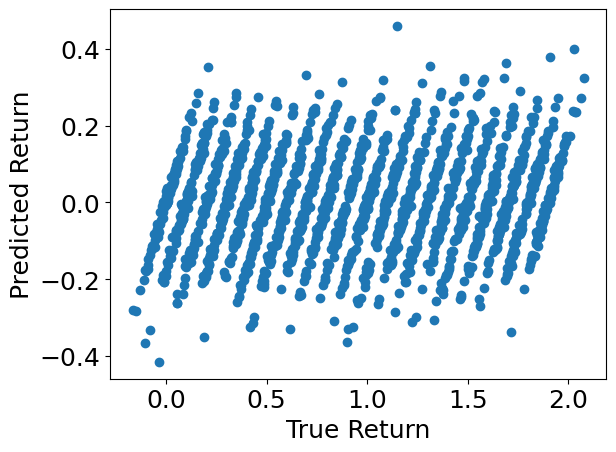

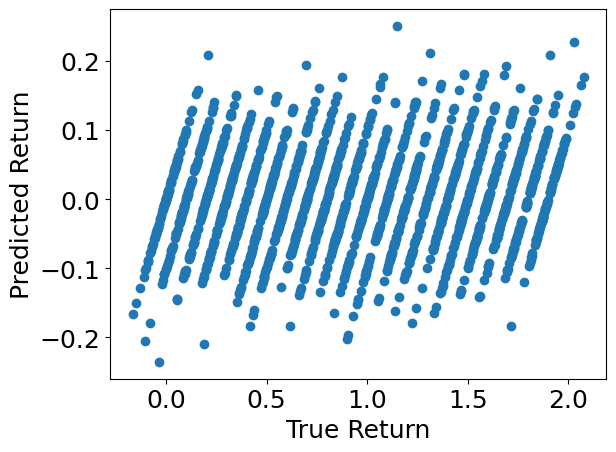

Mean-squared Error: 1.235
Correlation: -2.650177919101044


In [93]:
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(df['return'], df['OLS predicted_return'])
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.show()

plt.scatter(df['return'], df['Fixed Effects predicted_return'])
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.show()

from sklearn.metrics import mean_squared_error, r2_score
print(f'Mean-squared Error: {mean_squared_error(df["return"], df["Fixed Effects predicted_return"])}')
print(f'Correlation: {r2_score(df["return"], df["Fixed Effects predicted_return"])}')

KeyError: 'predicted_return'

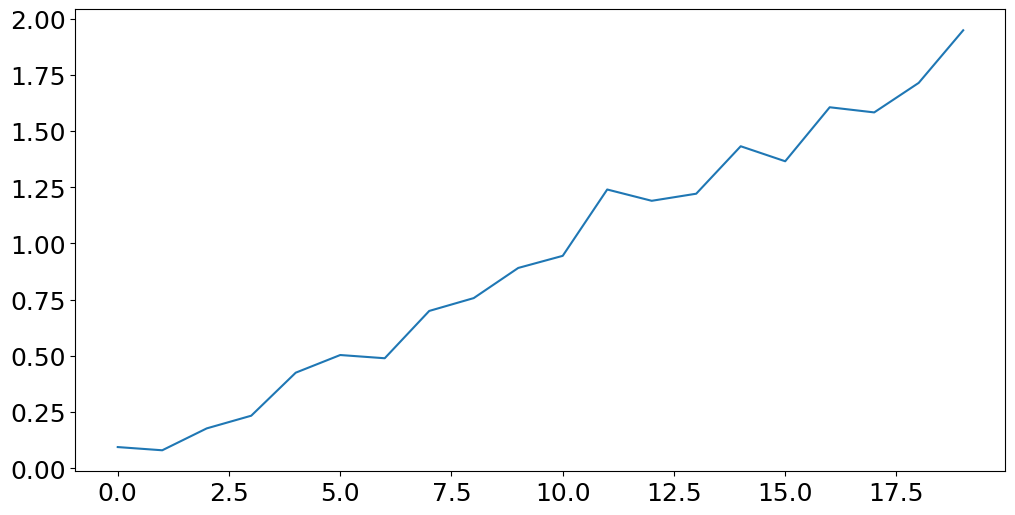

In [94]:
# Plot for first 5 stocks
fig, ax = plt.subplots(figsize=(12, 6))
sample_stocks = df_reset["stock_id"].unique()[1:2]

for stock in sample_stocks:
    stock_data = df_reset[df_reset["stock_id"] == stock]
    ax.plot(stock_data["quarter"], stock_data["return"], label=f"{stock} Actual", linestyle='-')
    ax.plot(stock_data["quarter"], stock_data["predicted_return"], label=f"{stock} Predicted", linestyle='--')

ax.set_title("Actual vs Predicted Returns for Sample Stocks")
ax.set_xlabel("Quarter")
ax.set_ylabel("Return")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
df = df.reset_index()

# ----- Get stock embeddings from the trained model -----
embedder.eval()
with torch.no_grad():
    stock_embeddings = embedder.stock_embedding.weight.cpu().numpy()  # shape: [100, 4]

# Create a DataFrame mapping stock name to its embedding
embedding_df = pd.DataFrame(stock_embeddings, columns=[f"embed_dim_{i}" for i in range(embedding_dim)])
embedding_df["stock_id"] = [f"Stock_{i}" for i in range(n_stocks)]

# ----- Merge embeddings into the panel -----
df = df.merge(embedding_df, on="stock_id", how="left")

df.head()

,stock_id,quarter,industry,div_yield_change,ptb_change,stock_slope,stock_bias,time_bias,return,predicted_return,embed_dim_0,embed_dim_1,embed_dim_2,embed_dim_3
0,Stock_0,0,0,0.049671,-0.067518,0.65,0,0.000000,0.045790,0.045771,0.028365,0.626124,-0.003805,-0.73686
1,Stock_0,1,0,-0.013826,-0.014452,0.65,0,0.252441,0.246344,-0.007518,0.028365,0.626124,-0.003805,-0.73686
2,Stock_0,2,0,0.064769,-0.079242,0.65,0,0.272789,0.330737,0.058301,0.028365,0.626124,-0.003805,-0.73686
3,Stock_0,3,0,0.152303,-0.030796,0.65,0,0.042336,0.147492,0.112660,0.028365,0.626124,-0.003805,-0.73686
4,Stock_0,4,0,-0.023415,-0.189361,0.65,0,-0.227041,-0.204388,0.013171,0.028365,0.626124,-0.003805,-0.73686


In [ ]:
# Use stock_id and quarter as context
context_df = df[["embed_dim_0", "embed_dim_1", "embed_dim_2", "embed_dim_3", "quarter"]].copy()
context_df["quarter"] = context_df["quarter"].astype(int)

# Predictors
X = df[["div_yield_change", "ptb_change"]].values
Y = df["return"].values.reshape(-1, 1)
C = context_df.values  # context = (stock_id, quarter)

In [ ]:
# -------------------------------
# 3. Split and normalize
# -------------------------------

C_train, C_test, X_train, X_test, Y_train, Y_test = train_test_split(C, X, Y, test_size=0.2, random_state=42)

def normalize(train, test):
    mean = train.mean(axis=0)
    std = train.std(axis=0)
    return (train - mean) / std, (test - mean) / std

In [ ]:
model = ContextualizedRegressor()
model.fit(C, X, Y,
          encoder_type="mlp",
          max_epochs=10,
          learning_rate=1e-2)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/edocampione/Desktop/Meng Engineering Science/4YP/scripts/lightning_logs/boot_0_checkpoints exists and is not empty.

  | Name      | Type           | Params | Mode 
-----------------------------------------------------
0 | metamodel | NaiveMetamodel | 1.5 K  | train
-----------------------------------------------------
1.5 K     Trainable params
0         Non-trainable params
1.5 K     Total params
0.006     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck.

In [ ]:
contextualized_coeffs, contextualized_offsets = model.predict_params(C)
Y_pred = model.predict(C, X)

from sklearn.metrics import mean_squared_error, r2_score
print(f'Mean-squared Error: {mean_squared_error(Y, Y_pred)}')
print(f'Correlation: {r2_score(Y, Y_pred)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Mean-squared Error: 0.038789002414745824
Correlation: 0.18700077757323796


In [ ]:
contextualized_coeffs, contextualized_offsets

(array([[[ 0.72590691,  0.03253784]],
 
        [[ 0.62173057, -0.10757285]],
 
        [[ 0.62166619, -0.10767265]],
 
        ...,
 
        [[ 0.72590691,  0.03253784]],
 
        [[ 0.72590691,  0.03253784]],
 
        [[ 0.72590691,  0.03253784]]]),
 array([[0.03450246],
        [0.27834868],
        [0.27851519],
        ...,
        [0.03450246],
        [0.03450246],
        [0.03450246]]))

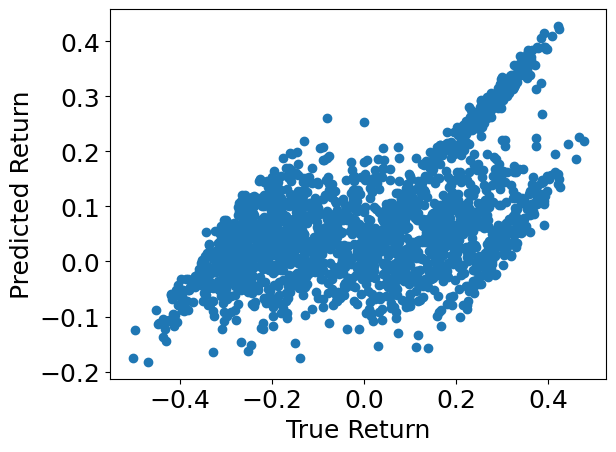

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 18})

plt.scatter(Y, Y_pred)
plt.xlabel("True Return")
plt.ylabel("Predicted Return")
plt.show()